In [1]:
import os
import requests
import zipfile
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, pyplot as plt

# INPUTS
# Choices of Country Border geojson Resolutions.
resolution_choices = ["01M", "03M", "10M", "30M", "60M"]

# resolution_choices[4] is 60M
res = resolution_choices[4]

# Choose country from ISO code
# country = "US"
country = "GR"

continent = "eu"  # na=North America, sa=South America, au=Australia, eu=Europe

print("Getting World's Country Borders")
world_country_borders = gpd.read_file(
    f"https://gisco-services.ec.europa.eu/distribution/v2/countries/geojson/CNTR_RG_{res}_2020_4326.geojson")
print(f"Filtering Country Border for: {country}")
country_border = world_country_borders[world_country_borders["CNTR_ID"] == country]



Getting World's Country Borders
Filtering Country Border for: GR


In [12]:
country_border

,id,CNTR_ID,CNTR_NAME,NAME_ENGL,NAME_FREN,ISO3_CODE,SVRG_UN,CAPT,EU_STAT,EFTA_STAT,CC_STAT,NAME_GERM,FID,geometry


In [10]:
# Clip US border to just CONUS - excludes Alaska, etc.
if country == "US":
    country_border = country_border.clip_by_rect(-140, 20, -50, 50)
    # clip_by_rect returns a geoseries, so turning back to a GDF
    country_border = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries(country_border))
    country_border.plot()

In [ ]:
# Get Continent-wide Watershed Basin Boundaries
print(f"Getting Watershed Basin for Continent: {continent}")
url = f"https://data.hydrosheds.org/file/HydroBASINS/standard/hybas_{continent}_lev03_v1c.zip"
file_name = url.split("/")[-1]

r = requests.get(url)
with open(file_name, 'wb') as outfile:
    outfile.write(r.content)

with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall()

# Intersect Basin with only the wanted Country Boundary.
print("Intersecting Country Border with Continent Watershed Basin.")
continent_basin = gpd.read_file(file_name.split(".")[0]+".shp")
country_basin = gpd.overlay(
    country_border, continent_basin, how='intersection')
country_basin.plot()


Getting Watershed Basin for Continent: eu
Intersecting Country Border with Continent Watershed Basin.


ValueError: aspect must be finite and positive 

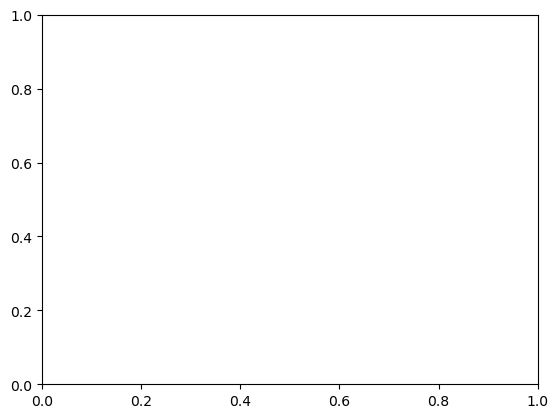

In [9]:
country_basin.plot()

In [8]:
# Get Rivers
print("Getting Continent Rivers.")
url = f"https://data.hydrosheds.org/file/HydroRIVERS/HydroRIVERS_v10_{continent}_shp.zip"
file_name = url.split("/")[-1]

r = requests.get(url)
with open(file_name, 'wb') as outfile:
    outfile.write(r.content)

with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall()

continent_rivers = gpd.read_file(os.path.join(
    f"HydroRIVERS_v10_{continent}_shp", f"HydroRIVERS_v10_{continent}.shp"))

# Clip rivers to country_basin extent.
print("Intersecting Rivers with Country-wide watershed basin.")
country_river_basin = gpd.overlay(
    continent_rivers, country_basin, how='intersection')
country_river_basin

Getting Continent Rivers.


KeyboardInterrupt: 

In [5]:

# RIVER WIDTH config
country_river_basin['ORD_FLOW'].unique()

def assign_river_width(row):
    if row['ORD_FLOW'] == 1:
        return 0.8
    elif row['ORD_FLOW'] == 2:
        return 0.7
    elif row['ORD_FLOW'] == 3:
        return 0.6
    elif row['ORD_FLOW'] == 4:
        return 0.45
    elif row['ORD_FLOW'] == 5:
        return 0.35
    elif row['ORD_FLOW'] == 6:
        return 0.25
    elif row['ORD_FLOW'] == 7:
        return 0.2
    elif row['ORD_FLOW'] == 8:
        return 0.15
    elif row['ORD_FLOW'] == 9:
        return 0.1
    else:
        return 0

print("apply width values to rivers.")
country_river_basin['width'] = country_river_basin.apply(
    assign_river_width, axis=1)

country_river_basin['HYBAS_ID'].unique()

apply width values to rivers.


array([], dtype=int64)

In [7]:
country_river_basin

,HYRIV_ID,NEXT_DOWN_1,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,...,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry,width


Setup Plot


ValueError: aspect must be finite and positive 

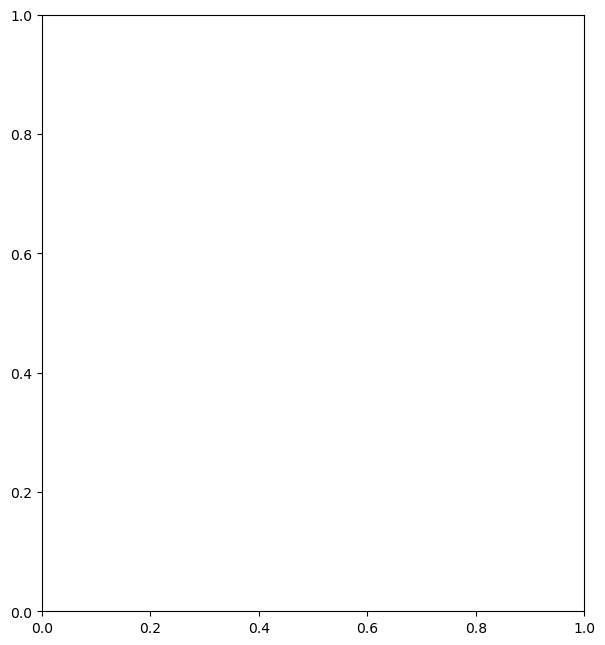

In [6]:
# PLOT
print("Setup Plot")
fig, ax = plt.subplots(figsize=(7, 7.75))
country_river_basin.plot(ax=ax, column='HYBAS_ID', cmap=colormaps['twilight'],
                            linewidth=country_river_basin['width'],
                            #  edgecolor='black',
                            #  alpha=country_river_basin['width'],
                            categorical=True,
                            #  legend=True
                            )
ax.set_axis_off()

In [ ]:
print("Save Plot")
fig.savefig(f'{country}-river-basins.png', dpi=600,
            bbox_inches='tight', pad_inches=0, transparent=True)

